# Distribution of True Stellar Rotational Velocities

In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

import scipy.stats as stats

Where the variable $x \equiv v$ is the true rotational velocity, and $y \equiv v \sin i$ is the projected rotational velocity. The variable $x$ follows a distribution $f_X(x)$, and the variable $y$ follows a distribution $f_Y(y)$. The parameter $\alpha$ is a constant that depends on the specific characteristics of the system being modeled.

The function designed in this proyect is

$$f_Y(y) = \int_y^\infty \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 + y^2}} f_X(x) \, dx$$

In [189]:
# Load the datasets
gendata, yuddata = pd.read_csv('data/geneve.dat', header=None), pd.read_csv('data/Yudin.dat', header=None)
gendata.columns, yuddata.columns = ['vsini'], ['vsini']

In [190]:
gendata.describe(), yuddata.describe()

(              vsini
 count  11818.000000
 mean       7.725503
 std        6.391010
 min        0.000000
 25%        3.000000
 50%        6.000000
 75%       10.000000
 max       29.000000,
             vsini
 count  462.000000
 mean   212.474026
 std     69.252739
 min     18.000000
 25%    162.000000
 50%    216.000000
 75%    262.000000
 max    422.000000)

In [191]:
gendata.min(), gendata.max(), yuddata.min(), yuddata.max()

(vsini    0
 dtype: int64,
 vsini    29
 dtype: int64,
 vsini    18
 dtype: int64,
 vsini    422
 dtype: int64)

By expert knowledge, we know that any star has a rotational velocity $v \leq 0$ km/s. Therefore, we have to remove the values where this condition is met.

In [192]:
print("Gendata vsini <= 0 count:",gendata[gendata.vsini <=0].vsini.count())
print("Yuddata vsini <= 0 count:",yuddata[yuddata.vsini <= 0].vsini.count())

gendata, yuddata = gendata[gendata.vsini > 0], yuddata[yuddata.vsini > 0]

Gendata vsini <= 0 count: 133
Yuddata vsini <= 0 count: 0


First we will create the Kernel Density Estimation (KDE) function for the given $v \sin{i}$ data points, that represents the projected rotational velocities of stars. The KDE function will help us estimate the probability density function of the data $f_Y(y)$.

<function matplotlib.pyplot.show(close=None, block=None)>

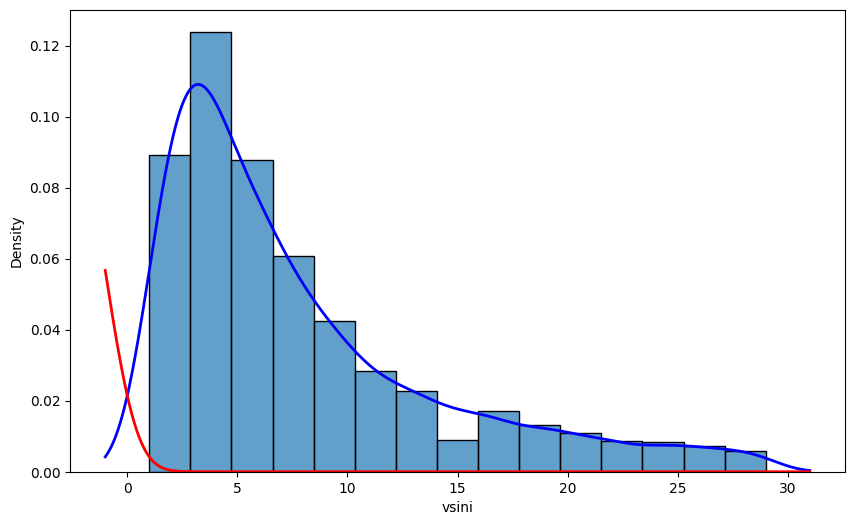

In [214]:
kdeplus = stats.gaussian_kde(
    dataset=gendata.vsini,
    bw_method='silverman'
)
kdenegs = stats.gaussian_kde(
    dataset=-gendata.vsini,
    bw_method='silverman',
)

vsinimax, vsinimin = max(gendata.vsini)+2, min(gendata.vsini-2)
vsinirange = np.linspace(start=vsinimin, stop=vsinimax, num=1000)
kdeplus_values = kdeplus.evaluate(vsinirange)
kdenegs_values = kdenegs.evaluate(vsinirange)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    vsinirange,
    kdeplus_values,
    color='blue',
    lw=2,
    label='KDE (Silverman)'
)
ax.plot(
    vsinirange,
    kdenegs_values,
    color='red',
    lw=2,
    label='KDE (Silverman)'
)
sns.histplot(
    data=gendata,
    x='vsini',
    bins=15,
    stat='density',
    edgecolor='black',
    alpha=0.7,
    label='Histogram',
    ax=ax
)

plt.show

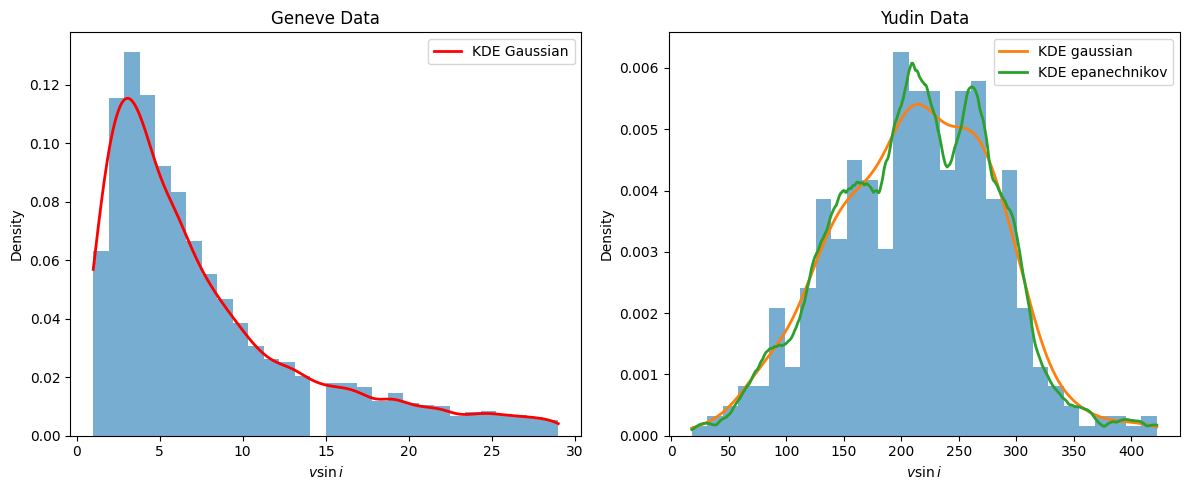

In [172]:
def silverman_rule(data):
    # Regla de oro: h = 0.9 * min(std, IQR/1.34) * n^(-1/5)
    n = len(data)
    std = np.std(data, ddof=1)
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    # Si el IQR es 0 (datos muy concentrados), usamos solo la std
    if iqr == 0:
        h = 0.9 * std * (n ** -0.2)
    else:
        h = 0.9 * min(std, iqr / 1.34) * (n ** -0.2)
    return h

genx = np.linspace(gendata.vsini.min(), gendata.vsini.max(), num_points)
yudx = np.linspace(yuddata.vsini.min(), yuddata.vsini.max(), num_points)

# --- 2. Preparar datos y calcular ancho de banda ---
bw_gen = silverman_rule(gendata['vsini'].values)
bw_yud = silverman_rule(yuddata['vsini'].values)

genkde = KernelDensity(kernel='gaussian', bandwidth=bw_gen).fit(gendata.vsini.values.reshape(-1, 1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
num_points = 500
ifdensity = True

axes[0].hist(gendata['vsini'], bins=30, density=ifdensity, alpha=0.6,)
axes[1].hist(yuddata['vsini'], bins=30, density=ifdensity, alpha=0.6,)

axes[0].plot(genx, np.exp(genkde.score_samples(genx.reshape(-1, 1))), color='red', lw=2, label='KDE Gaussian')

#kernellist = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
kernellist = ['gaussian', 'epanechnikov']
#kernellist = ['gaussian']
for kernel in kernellist:
    yudkde = KernelDensity(kernel=kernel, bandwidth=bw_yud).fit(yuddata.vsini.values.reshape(-1, 1))
    axes[1].plot(yudx, np.exp(yudkde.score_samples(yudx.reshape(-1, 1))), alpha=1.0, lw=2, label=f'KDE {kernel}')
axes[0].set_title('Geneve Data')
axes[1].set_title('Yudin Data')

for ax in axes:
    ax.legend()
    ax.set_xlabel(r'$v\sin{i}$')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

Now we will create a meshgrid for the variables $x$ and $y$. The meshgrid will allow us to evaluate the integral for a range of values of $x$ and $y$.

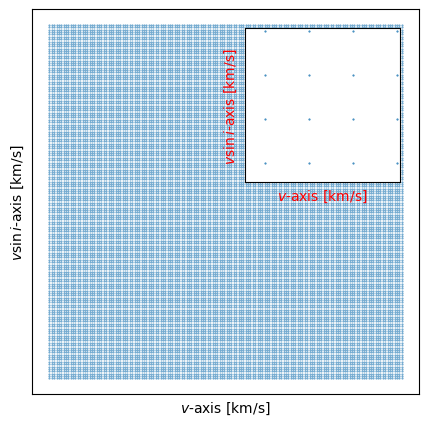

In [187]:
N = 150
a, b = 0.1, 30
dxx = (b - a)/N
dyy = (b - a + dxx/2)/N
xx = a + dxx * (np.arange(N)-0.05)
yy = a + dyy * (np.arange(N)-0.05)

meshx, meshy = np.meshgrid(xx, yy)

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(meshx, meshy, s=1, marker='.', alpha=0.7)
ax.axis('equal')
ax.set_xlabel(r'$v$-axis [km/s]')
ax.set_ylabel(r'$v\sin{i}$-axis [km/s]')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
axins = ax.inset_axes([0.55, 0.55, 0.4, 0.4], xlim=(0, dxx+0.5), ylim=(0, dyy+0.5))
axins.scatter(meshx, meshy, s=1, marker='.')
axins.set_xlabel(r'$v$-axis [km/s]',color='red')
axins.set_ylabel(r'$v\sin{i}$-axis [km/s]', color='red')
axins.set_yticklabels([])
axins.set_xticklabels([])
axins.set_xticks([])
axins.set_yticks([])
plt.show()

Now we will using the matrix form for our objetive equation: 
$$Y = AX$$

where $Y = f_Y(y)$, $X = f_X(x)$, and $A$ is the matrix that contains the values of the integrand evaluated at the meshgrid points.